# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # For progress bar
warnings.filterwarnings('ignore')

# import sys

# sys.path.append('../../') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *
from libs.nestedsness_calculator import *
from libs.curveball import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [3]:
country = "us"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 22,527
Investors: 38,843
Investments: 147,832
Funding rounds: 268,283


## VC-Bipartite Network Construction

In [4]:
vc_investments = extract_vc_investments(cleaned_data['investments'])

vc_investments['investor_uuid'] = vc_investments[['investor_uuid', 'investment_type']].agg('-'.join, axis=1)
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)

early_stages = set(['angel', 'pre_seed', 'seed', 'series_a'])
vc_early_investments = vc_investments[vc_investments['investment_type'].isin(early_stages)]

late_stages = set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i', 'series_unknown'])
vc_late_investments = vc_investments[vc_investments['investment_type'].isin(late_stages)]

print("\nSample of VC investments:")
display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
print(vc_investments[display_cols].head())

print("\VC-VC pairs:")
vc_vc_investments_pairs = create_investment_pairs(vc_early_investments, vc_late_investments, 'left_vc', 'right_vc')
vc_vc_investments_pairs['announced_year'] = vc_vc_investments_pairs[['announced_year_left_vc', 'announced_year_right_vc']].max(axis=1)
vc_vc_investments_pairs['total_funding_usd'] = (vc_vc_investments_pairs['total_funding_usd_left_vc'])
print(vc_vc_investments_pairs[['org_uuid', 'investor_name_left_vc', 'total_funding_usd_left_vc','total_funding_usd_right_vc']].head())

Found 104618 VC investments
Unique companies with VC funding: 16932

Sample of VC investments:
  company_name                        investor_name            investor_types  \
0       Scribd                    Redpoint-series_a           venture capital   
1      MeetMoi       Acadia Woods Partners-series_a           venture capital   
2        OpenX         First Round Capital-series_a           venture capital   
3        OpenX  Oreilly AlphaTech Ventures-series_a  micro vc,venture capital   
4        OpenX   Mangrove Capital Partners-series_a           venture capital   

   total_funding_usd  
0        106750000.0  
1          5575000.0  
2         70511200.0  
3         70511200.0  
4         70511200.0  
\VC-VC pairs:
Created 200727 investment pairs
Covering 5237 unique investors
                               org_uuid investor_name_left_vc  \
0  21e77067-5537-408e-cad7-e5e72bb6ad86     Redpoint-series_a   
1  21e77067-5537-408e-cad7-e5e72bb6ad86     Redpoint-series_a   
2  21e77

In [5]:
# Extract year from funding rounds for time series analysis
# Merge investment data with funding rounds to get temporal information
# vc_vc_inv_pairs_clean = vc_vc_investments_pairs.copy()
# Count occurrences of each VC across both columns
all_vcs = pd.Series(
  list(vc_vc_investments_pairs['investor_name_left_vc']) + 
  list(vc_vc_investments_pairs['investor_name_right_vc'])
)
vc_counts = all_vcs.value_counts()

# Get the top 30% most connected VCs
top_percent = int(len(vc_counts) * 0.3)
top_vcs = vc_counts.head(top_percent).index.tolist()

# Filter to keep only connections between top VCs
vc_vc_inv_pairs_clean = vc_vc_investments_pairs[
  (vc_vc_investments_pairs['investor_name_left_vc'].isin(top_vcs)) & 
  (vc_vc_investments_pairs['investor_name_right_vc'].isin(top_vcs))
].copy()

print(f"Filtered to {len(vc_vc_inv_pairs_clean)} investments between top {len(top_vcs)} VCs")

# Convert to datetime and extract year
# vc_vc_inv_pairs_clean['announced_year'] = pd.to_datetime(vc_vc_inv_pairs_clean['announced_year'])
vc_vc_inv_pairs_clean['year'] = vc_vc_inv_pairs_clean['announced_year']

# Get the range of years
min_year = 2005
max_year = 2023

# Filter out rows with missing dates
vc_vc_inv_pairs_clean = vc_vc_inv_pairs_clean.dropna(subset=['year'])
vc_vc_inv_pairs_clean = vc_vc_inv_pairs_clean[(vc_vc_inv_pairs_clean['year'] >= min_year) & (vc_vc_inv_pairs_clean['year'] <= max_year)]


print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(vc_vc_inv_pairs_clean):,}")

# Show distribution by year
year_counts = vc_vc_inv_pairs_clean['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Filtered to 131756 investments between top 6064 VCs
Time series analysis from 2005 to 2023
Total investments with dates: 125,489

Investments per year:
year
2005      165
2006      122
2007      188
2008      206
2009      218
2010      376
2011      628
2012      599
2013     1118
2014     2176
2015     4430
2016     6304
2017     7816
2018    11040
2019    15655
2020    18198
2021    33099
2022    17152
2023     5999
Name: count, dtype: int64


## Static Ecological Network Analysis

In [6]:
# Create the bipartite adjacency matrix
# Extract unique left and right VCs to define matrix dimensions
left_vcs = vc_vc_inv_pairs_clean['investor_name_left_vc'].unique()
right_vcs = vc_vc_inv_pairs_clean['investor_name_right_vc'].unique()

# Create index mappings for efficient matrix construction
left_vc_indices = {vc: i for i, vc in enumerate(left_vcs)}
right_vc_indices = {vc: j for j, vc in enumerate(right_vcs)}

# Initialize matrix with zeros
adjacency_matrix = np.zeros((len(left_vcs), len(right_vcs)))

# Fill matrix with 1s where connections exist
for _, row in vc_vc_inv_pairs_clean.iterrows():
    left_idx = left_vc_indices[row['investor_name_left_vc']]
    right_idx = right_vc_indices[row['investor_name_right_vc']]
    adjacency_matrix[left_idx, right_idx] = 1

# Create a DataFrame for easier visualization if needed
adjacency_df = pd.DataFrame(
    adjacency_matrix, 
    index=left_vcs,
    columns=right_vcs
)

print(f"Bipartite matrix shape: {adjacency_matrix.shape}")
print(f"Number of connections: {int(adjacency_matrix.sum())}")
print(f"Matrix density: {adjacency_matrix.mean():.4f}")

Bipartite matrix shape: (2744, 3277)
Number of connections: 110842
Matrix density: 0.0123


Nestedness (NODF): 0.0444


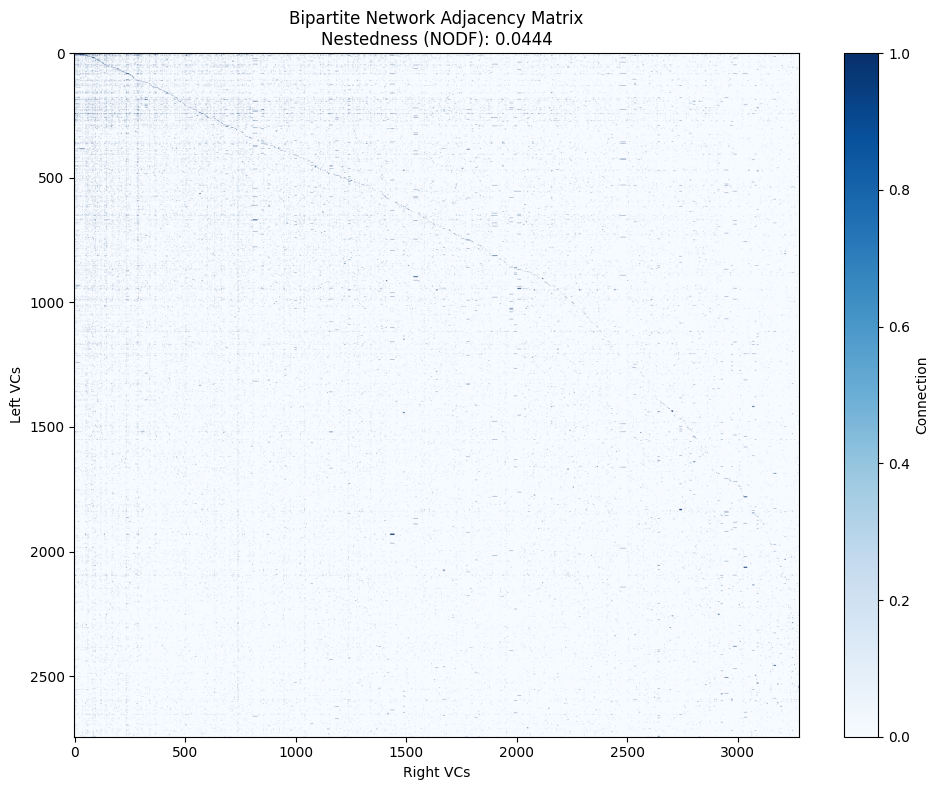

In [7]:
calculator = NestednessCalculator(adjacency_matrix)
nestedness_score = calculator.nodf(adjacency_matrix)

print(f"Nestedness (NODF): {nestedness_score:.4f}")

# You can also visualize the adjacency matrix to see patterns
plt.figure(figsize=(10, 8))
plt.imshow(adjacency_matrix, cmap='Blues', aspect='auto')
plt.colorbar(label='Connection')
plt.title(f'Bipartite Network Adjacency Matrix\nNestedness (NODF): {nestedness_score:.4f}')
plt.xlabel('Right VCs')
plt.ylabel('Left VCs')
plt.tight_layout()
plt.show()

In [8]:
""" # Calculate observed nestedness score (already done in your code)
# nestedness_score = calculator.nodf(adjacency_matrix)
print(f"Observed Nestedness (NODF): {nestedness_score:.4f}")

# Generate null models and calculate their nestedness scores
n_iterations = 100  # Number of null models to generate
null_nestedness_scores = []

print(f"Generating {n_iterations} null models (preserving degrees)...")
for i in tqdm(range(n_iterations)):
    # Generate a null model matrix by swapping while preserving degrees
    M = adjacency_matrix.copy()
    r_hp = find_presences(M)
    RM = curve_ball(M, r_hp, 100000)
    
    null_matrix = RM.astype(adjacency_matrix.dtype)

    # Calculate nestedness of the null model
    try:
        calculator_null = NestednessCalculator(null_matrix)
        null_score = calculator_null.nodf(null_matrix)
        null_nestedness_scores.append(null_score)
    except Exception as e:
        print(f"Error in iteration {i}: {e}") """

' # Calculate observed nestedness score (already done in your code)\n# nestedness_score = calculator.nodf(adjacency_matrix)\nprint(f"Observed Nestedness (NODF): {nestedness_score:.4f}")\n\n# Generate null models and calculate their nestedness scores\nn_iterations = 100  # Number of null models to generate\nnull_nestedness_scores = []\n\nprint(f"Generating {n_iterations} null models (preserving degrees)...")\nfor i in tqdm(range(n_iterations)):\n    # Generate a null model matrix by swapping while preserving degrees\n    M = adjacency_matrix.copy()\n    r_hp = find_presences(M)\n    RM = curve_ball(M, r_hp, 100000)\n\n    null_matrix = RM.astype(adjacency_matrix.dtype)\n\n    # Calculate nestedness of the null model\n    try:\n        calculator_null = NestednessCalculator(null_matrix)\n        null_score = calculator_null.nodf(null_matrix)\n        null_nestedness_scores.append(null_score)\n    except Exception as e:\n        print(f"Error in iteration {i}: {e}") '

In [9]:
# Convert to numpy array for calculations
null_nestedness_scores_np = np.array(null_nestedness_scores)

# Calculate statistics
mean_null = np.mean(null_nestedness_scores_np)
std_null = np.std(null_nestedness_scores_np)
z_score = (nestedness_score - mean_null) / std_null
p_value = np.sum(null_nestedness_scores_np >= nestedness_score) / len(null_nestedness_scores_np)

print("\nNestedness Significance Analysis:")
print(f"Observed NODF: {nestedness_score:.4f}")
print(f"Null model mean NODF: {mean_null:.4f}")
print(f"Null model std dev: {std_null:.4f}")
print(f"Z-score: {z_score:.4f}")
print(f"Empirical p-value: {p_value:.4f}")
print(f"Significance: {'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05")

# Visualize the results
plt.figure(figsize=(10, 6))
sns.histplot(null_nestedness_scores_np, kde=True, color='skyblue')
plt.axvline(nestedness_score, color='red', linestyle='--', linewidth=2, 
            label=f'Observed (NODF={nestedness_score:.4f})')
plt.axvline(mean_null, color='black', linestyle='-', linewidth=1, 
            label=f'Null mean (NODF={mean_null:.4f})')
plt.title(f'Null Model Analysis of Nestedness\nZ-score: {z_score:.4f}, p-value: {p_value:.4f}', 
          fontsize=14)
plt.xlabel('Nestedness (NODF)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'null_nestedness_scores' is not defined

#### Comments

...

## Time Series Ecological Network Analysis

### Snapshot-based analysis

Not yet implemented...

In [ ]:
""" # Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_year_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[vc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_vc_vc_inv_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_vc_vc_inv_pairs)} investments)")
        continue
    
    try:
        # Analyze bipartite structure for this year
        year_analysis = analyze_bipartite_structure_robust(
            cur_year_vc_vc_inv_pairs[['investor_name_left_vc', 'investor_name_right_vc', 'total_funding_usd']],
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd',
            'VCs left',
            'VCs right',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        basic_metrics = year_analysis['basic_metrics']
        ecological_summary = year_analysis['ecological_summary']
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': basic_metrics['num_nodes'],
            'num_vcs_left': basic_metrics['set_0_size'],
            'num_vcs_right': basic_metrics['set_1_size'],
            'num_edges': basic_metrics['num_edges'],
            'density': basic_metrics['density'],
            'connectance': ecological_summary['connectance'],
            'nestedness_nodf': ecological_summary['nestedness_nodf'],
            'modularity': ecological_summary['modularity'],
            # 'cross_assortativity': ecological_summary['cross_assortativity'],
            'num_components': basic_metrics['num_components']
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {basic_metrics['num_nodes']} nodes, {basic_metrics['num_edges']} edges, "
              f"Connectance: {ecological_summary['connectance']:.3f}, "
              f"Nestedness: {ecological_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {ecological_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years") """

Computing ecological metrics for each year...
Year 2005: 111 nodes, 163 edges, Connectance: 0.053, Nestedness: 4.1, Modularity: 0.454
Year 2006: 117 nodes, 119 edges, Connectance: 0.035, Nestedness: 2.4, Modularity: 0.462
Year 2007: 148 nodes, 178 edges, Connectance: 0.033, Nestedness: 2.4, Modularity: 0.459
Year 2008: 172 nodes, 197 edges, Connectance: 0.027, Nestedness: 2.7, Modularity: 0.448
Year 2009: 179 nodes, 212 edges, Connectance: 0.026, Nestedness: 1.9, Modularity: 0.475
Year 2010: 271 nodes, 365 edges, Connectance: 0.020, Nestedness: 2.1, Modularity: 0.465
Year 2011: 351 nodes, 602 edges, Connectance: 0.020, Nestedness: 2.7, Modularity: 0.420
Year 2012: 429 nodes, 576 edges, Connectance: 0.013, Nestedness: 1.5, Modularity: 0.453
Year 2013: 553 nodes, 1084 edges, Connectance: 0.014, Nestedness: 2.4, Modularity: 0.424
Year 2014: 929 nodes, 2087 edges, Connectance: 0.010, Nestedness: 1.9, Modularity: 0.379
Year 2015: 1277 nodes, 4272 edges, Connectance: 0.011, Nestedness: 2.3, 

In [ ]:
""" # Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis") """

Time Series Metrics Summary:
           year  num_nodes  num_vcs_left  num_vcs_right  num_edges  density  \
count    19.000     19.000        19.000         19.000     19.000   19.000   
mean   2014.000   1390.947       755.211        635.737   6369.211    0.017   
std       5.627   1338.941       731.574        609.964   8547.677    0.013   
min    2005.000    111.000        56.000         55.000    119.000    0.006   
25%    2009.500    225.000       106.500        118.500    288.500    0.007   
50%    2014.000    929.000       483.000        446.000   2087.000    0.011   
75%    2018.500   2232.000      1284.500       1001.000   9115.000    0.023   
max    2023.000   4301.000      2259.000       2042.000  31755.000    0.053   

       connectance  nestedness_nodf  modularity  num_components  
count       19.000           19.000      19.000          19.000  
mean         0.017            2.176       0.378          26.474  
std          0.013            0.605       0.078           8.9

Evolution of ecological metrics over time in the accelerator-VC ecosystem.

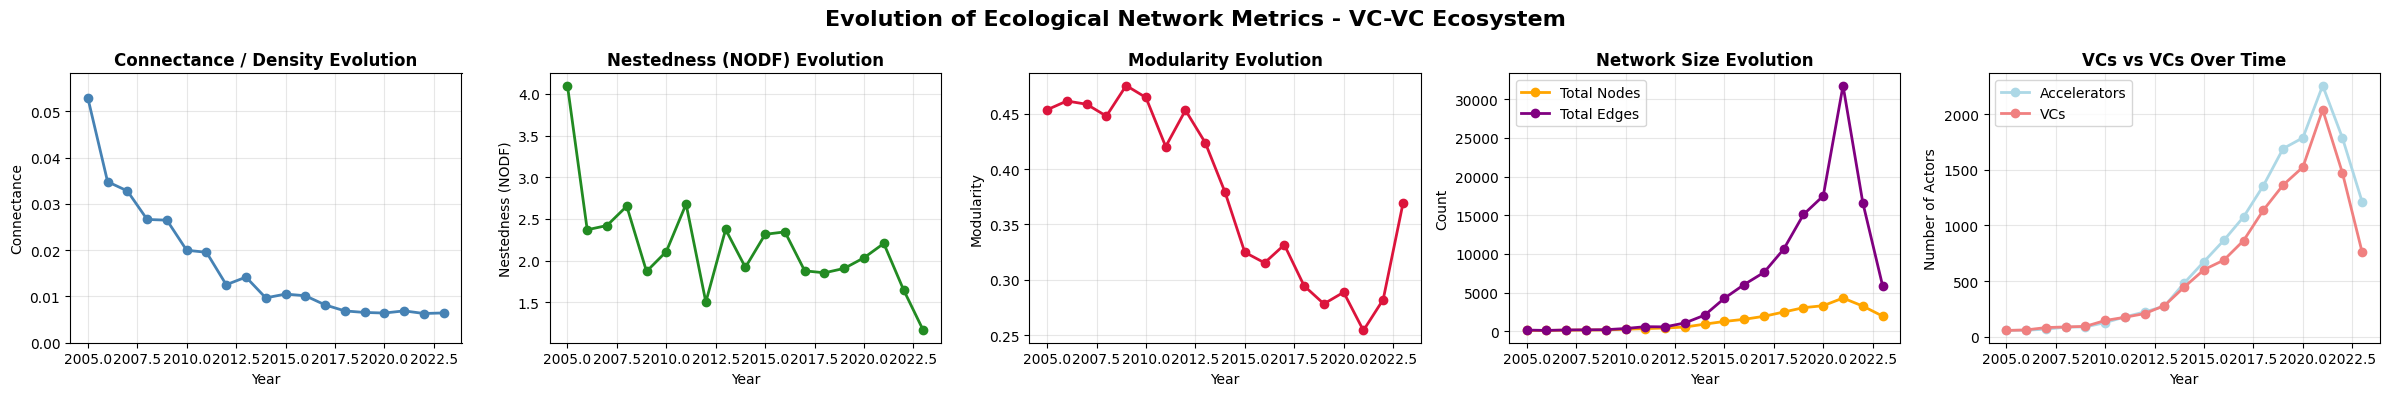

In [ ]:
""" if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 5, figsize=(24, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[2].plot(ts_df['year'], ts_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[3].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[3].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[3].set_title('Network Size Evolution', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(ts_df['year'], ts_df['num_vcs_left'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[4].plot(ts_df['year'], ts_df['num_vcs_right'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[4].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[4].set_xlabel('Year')
    axes[4].set_ylabel('Number of Actors')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization") """

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0026 per year (total: -0.0465)
nestedness_nodf: -0.1633 per year (total: -2.9388)
modularity: -0.0047 per year (total: -0.0847)
num_nodes: +103.1667 per year (total: +1857.0000)
num_edges: +318.8889 per year (total: +5740.0000)

Correlations between metrics and time:
connectance: r=-0.881 (decreasing trend)
nestedness_nodf: r=-0.638 (decreasing trend)
modularity: r=-0.874 (decreasing trend)


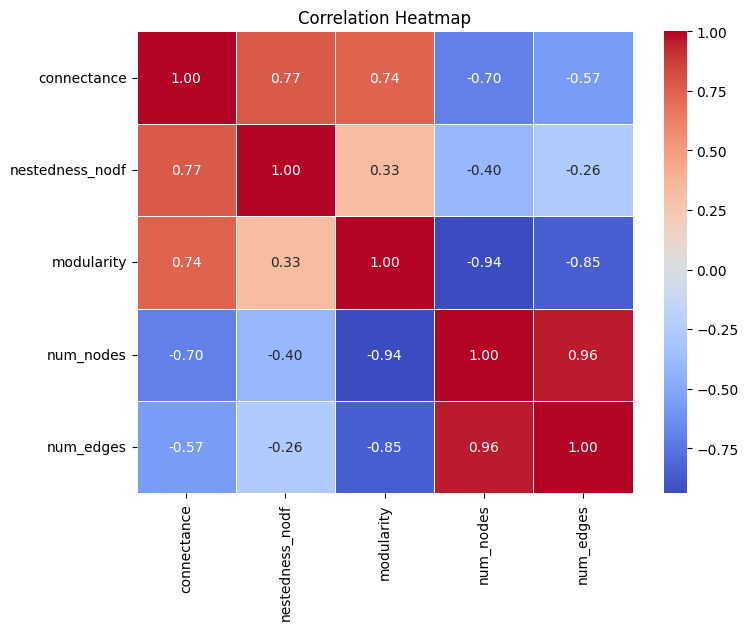

In [ ]:
""" if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_df.columns:
            correlation = ts_df['year'].corr(ts_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)") """

### Cumulative network analysis (5 years window)

In [19]:
# Initialize storage for time series metrics
cumulative_nestedness_scores_ts = []
cumulative_null_nestedness_scores_ts = []
cumulative_window = 5

vc_vc_inv_pairs_ts = vc_vc_inv_pairs_clean.copy()

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print(f"Computing ecological metrics for each year ({cumulative_window} years window)...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year + cumulative_window, max_year + 1):
    cur_window_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] <= year) & (vc_vc_inv_pairs_ts['year'] >= year - cumulative_window)]
    
    try:
        left_vcs_ts = cur_window_vc_vc_inv_pairs['investor_name_left_vc'].unique()
        right_vcs_ts = cur_window_vc_vc_inv_pairs['investor_name_right_vc'].unique()

        # Create index mappings for efficient matrix construction
        left_vc_indices_ts = {vc: i for i, vc in enumerate(left_vcs_ts)}
        right_vc_indices_ts = {vc: j for j, vc in enumerate(right_vcs_ts)}

        # Initialize matrix with zeros
        adjacency_matrix_ts = np.zeros((len(left_vcs_ts), len(right_vcs_ts)))

        # Fill matrix with 1s where connections exist
        for _, row in cur_window_vc_vc_inv_pairs.iterrows():
            left_idx_ts = left_vc_indices_ts[row['investor_name_left_vc']]
            right_idx_ts = right_vc_indices_ts[row['investor_name_right_vc']]
            adjacency_matrix_ts[left_idx_ts, right_idx_ts] = 1

        calculator_ts = NestednessCalculator(adjacency_matrix_ts)
        nestedness_score_ts = calculator_ts.nodf(adjacency_matrix_ts)
        
        null_nestedness_scores_ts = []
        n_iterations = 500
        n_iterations_cv = 50000
        print(f"Generating {n_iterations} null models (preserving degrees)...")
        for i in tqdm(range(n_iterations)):
            # Generate a null model matrix by swapping while preserving degrees
            M = adjacency_matrix.copy()
            r_hp = find_presences(M)
            RM = curve_ball(M, r_hp, n_iterations_cv)
            
            null_matrix = RM.astype(adjacency_matrix.dtype)

            # Calculate nestedness of the null model
            try:
                calculator_null = NestednessCalculator(null_matrix)
                null_score = calculator_null.nodf(null_matrix)
                null_nestedness_scores_ts.append(null_score)
            except Exception as e:
                print(f"Error in iteration {i}: {e}")
                
        null_nestedness_scores_np = np.array(null_nestedness_scores_ts)

        # Calculate statistics
        mean_null = np.mean(null_nestedness_scores_np)
        std_null = np.std(null_nestedness_scores_np)
        z_score = (nestedness_score_ts - mean_null) / std_null
        p_value = np.sum(null_nestedness_scores_np >= nestedness_score_ts) / len(null_nestedness_scores_np)

        num_nodes = len(left_vcs_ts) + len(right_vcs_ts)
        num_vcs_left = len(left_vcs_ts)
        num_vcs_right = len(right_vcs_ts)
        num_edges = int(adjacency_matrix_ts.sum())
        density = adjacency_matrix_ts.mean()
        
        cumulative_nestedness_scores_ts.append({
            'year': year,
            'nestedness_score': nestedness_score_ts,
            'null_nestedness_scores': null_nestedness_scores_np,
            'mean_null': mean_null,
            'std_null': std_null,
            'z_score': z_score,
            'p_value': p_value,
            'year': year,
            'num_nodes': num_nodes,
            'num_vcs_left': num_vcs_left,
            'num_vcs_right': num_vcs_right,
            'num_edges': num_edges,
            'density': density
        })
        
        # Extract metrics        
        print(f"Year {year}: {num_nodes} nodes ({num_vcs_left} left VCs, {num_vcs_right} right VCs), "
              f"{num_edges} edges, Density: {density:.4f}, "
              f"Nestedness: {nestedness_score_ts:.4f}, Mean null: {mean_null:.4f}, "
              f"Std null: {std_null:.4f}, Z-score: {z_score:.4f}, P-value: {p_value:.4f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(cumulative_nestedness_scores_ts)} years")

Computing ecological metrics for each year (5 years window)...
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:08<00:00,  1.94s/it]


Year 2010: 580 nodes (248 left VCs, 332 right VCs), 1134 edges, Density: 0.0138, Nestedness: 0.0229, Mean null: 0.0486, Std null: 0.0001, Z-score: -208.9096, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:24<00:00,  1.97s/it]


Year 2011: 729 nodes (325 left VCs, 404 right VCs), 1545 edges, Density: 0.0118, Nestedness: 0.0230, Mean null: 0.0486, Std null: 0.0001, Z-score: -221.7784, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:38<00:00,  2.00s/it]


Year 2012: 859 nodes (391 left VCs, 468 right VCs), 1952 edges, Density: 0.0107, Nestedness: 0.0224, Mean null: 0.0486, Std null: 0.0001, Z-score: -214.9749, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [17:01<00:00,  2.04s/it]


Year 2013: 1049 nodes (487 left VCs, 562 right VCs), 2817 edges, Density: 0.0103, Nestedness: 0.0231, Mean null: 0.0486, Std null: 0.0001, Z-score: -211.1750, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [18:21<00:00,  2.20s/it]


Year 2014: 1443 nodes (698 left VCs, 745 right VCs), 4605 edges, Density: 0.0089, Nestedness: 0.0241, Mean null: 0.0486, Std null: 0.0001, Z-score: -207.0936, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:22<00:00,  1.97s/it]


Year 2015: 1939 nodes (935 left VCs, 1004 right VCs), 8466 edges, Density: 0.0090, Nestedness: 0.0266, Mean null: 0.0486, Std null: 0.0001, Z-score: -183.7313, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:30<00:00,  1.98s/it]


Year 2016: 2469 nodes (1231 left VCs, 1238 right VCs), 13801 edges, Density: 0.0091, Nestedness: 0.0287, Mean null: 0.0486, Std null: 0.0001, Z-score: -175.6976, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:39<00:00,  2.00s/it]


Year 2017: 3060 nodes (1510 left VCs, 1550 right VCs), 20440 edges, Density: 0.0087, Nestedness: 0.0284, Mean null: 0.0486, Std null: 0.0001, Z-score: -169.5797, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:37<00:00,  1.99s/it]


Year 2018: 3758 nodes (1863 left VCs, 1895 right VCs), 29815 edges, Density: 0.0084, Nestedness: 0.0300, Mean null: 0.0486, Std null: 0.0001, Z-score: -162.0066, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:18<00:00,  1.96s/it]


Year 2019: 4476 nodes (2223 left VCs, 2253 right VCs), 42856 edges, Density: 0.0086, Nestedness: 0.0316, Mean null: 0.0486, Std null: 0.0001, Z-score: -139.0861, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:55<00:00,  2.03s/it]


Year 2020: 5063 nodes (2457 left VCs, 2606 right VCs), 57295 edges, Density: 0.0089, Nestedness: 0.0343, Mean null: 0.0486, Std null: 0.0001, Z-score: -115.7486, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [17:01<00:00,  2.04s/it]


Year 2021: 5673 nodes (2643 left VCs, 3030 right VCs), 83251 edges, Density: 0.0104, Nestedness: 0.0385, Mean null: 0.0486, Std null: 0.0001, Z-score: -85.1699, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:18<00:00,  1.96s/it]


Year 2022: 5868 nodes (2679 left VCs, 3189 right VCs), 93058 edges, Density: 0.0109, Nestedness: 0.0393, Mean null: 0.0486, Std null: 0.0001, Z-score: -80.5833, P-value: 1.0000
Generating 500 null models (preserving degrees)...


100%|██████████| 500/500 [16:39<00:00,  2.00s/it]

Year 2023: 5880 nodes (2671 left VCs, 3209 right VCs), 91798 edges, Density: 0.0107, Nestedness: 0.0375, Mean null: 0.0486, Std null: 0.0001, Z-score: -96.6461, P-value: 1.0000

Successfully analyzed 14 years


In [20]:
# Convert to DataFrame for easier analysis and plotting
cumulative_nestedness_scores_df = pd.DataFrame(cumulative_nestedness_scores_ts)

if len(cumulative_nestedness_scores_df) > 0:
    print("Time Series Metrics Summary:")
    print(cumulative_nestedness_scores_df.describe().round(3))
    
    print(f"\nData available for years: {cumulative_nestedness_scores_df['year'].min()} to {cumulative_nestedness_scores_df['year'].max()}")
    print(f"Number of years analyzed: {len(cumulative_nestedness_scores_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  nestedness_score  mean_null  std_null  z_score  p_value  \
count    14.000            14.000     14.000      14.0   14.000     14.0   
mean   2016.500             0.029      0.049       0.0 -162.299      1.0   
std       4.183             0.006      0.000       0.0   50.547      0.0   
min    2010.000             0.022      0.049       0.0 -221.778      1.0   
25%    2013.250             0.023      0.049       0.0 -208.456      1.0   
50%    2016.500             0.029      0.049       0.0 -172.639      1.0   
75%    2019.750             0.034      0.049       0.0 -121.583      1.0   
max    2023.000             0.039      0.049       0.0  -80.583      1.0   

       num_nodes  num_vcs_left  num_vcs_right  num_edges  density  
count     14.000        14.000         14.000     14.000   14.000  
mean    3060.429      1454.357       1606.071  32345.214    0.010  
std     2035.500       954.664       1084.880  35186.601    0.002  
min      580.0

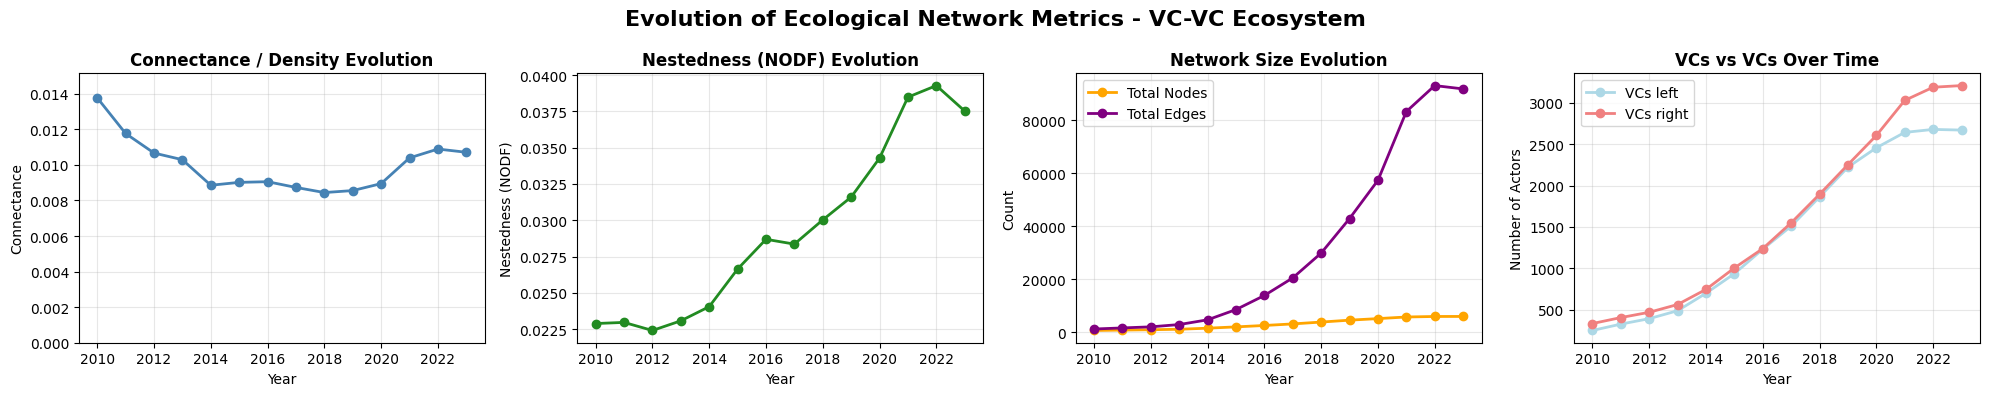

In [21]:
if len(cumulative_nestedness_scores_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['density'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(cumulative_nestedness_scores_df['density']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['nestedness_score'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    """ axes[2].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3) """
    
    # Network size evolution
    axes[2].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[2].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[2].set_title('Network Size Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Count')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    axes[3].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['num_vcs_left'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='VCs left')
    axes[3].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['num_vcs_right'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs right')
    axes[3].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Number of Actors')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")


Nestedness Significance Analysis for Year 2010:
Observed NODF: 0.0229
Null model mean NODF: 0.0486
Null model std dev: 0.0001
Z-score: -208.9096
Empirical p-value: 1.0000
Significance: Not significant at α=0.05

Nestedness Significance Analysis for Year 2011:
Observed NODF: 0.0230
Null model mean NODF: 0.0486
Null model std dev: 0.0001
Z-score: -221.7784
Empirical p-value: 1.0000
Significance: Not significant at α=0.05

Nestedness Significance Analysis for Year 2012:
Observed NODF: 0.0224
Null model mean NODF: 0.0486
Null model std dev: 0.0001
Z-score: -214.9749
Empirical p-value: 1.0000
Significance: Not significant at α=0.05

Nestedness Significance Analysis for Year 2013:
Observed NODF: 0.0231
Null model mean NODF: 0.0486
Null model std dev: 0.0001
Z-score: -211.1750
Empirical p-value: 1.0000
Significance: Not significant at α=0.05

Nestedness Significance Analysis for Year 2014:
Observed NODF: 0.0241
Null model mean NODF: 0.0486
Null model std dev: 0.0001
Z-score: -207.0936
Empiri

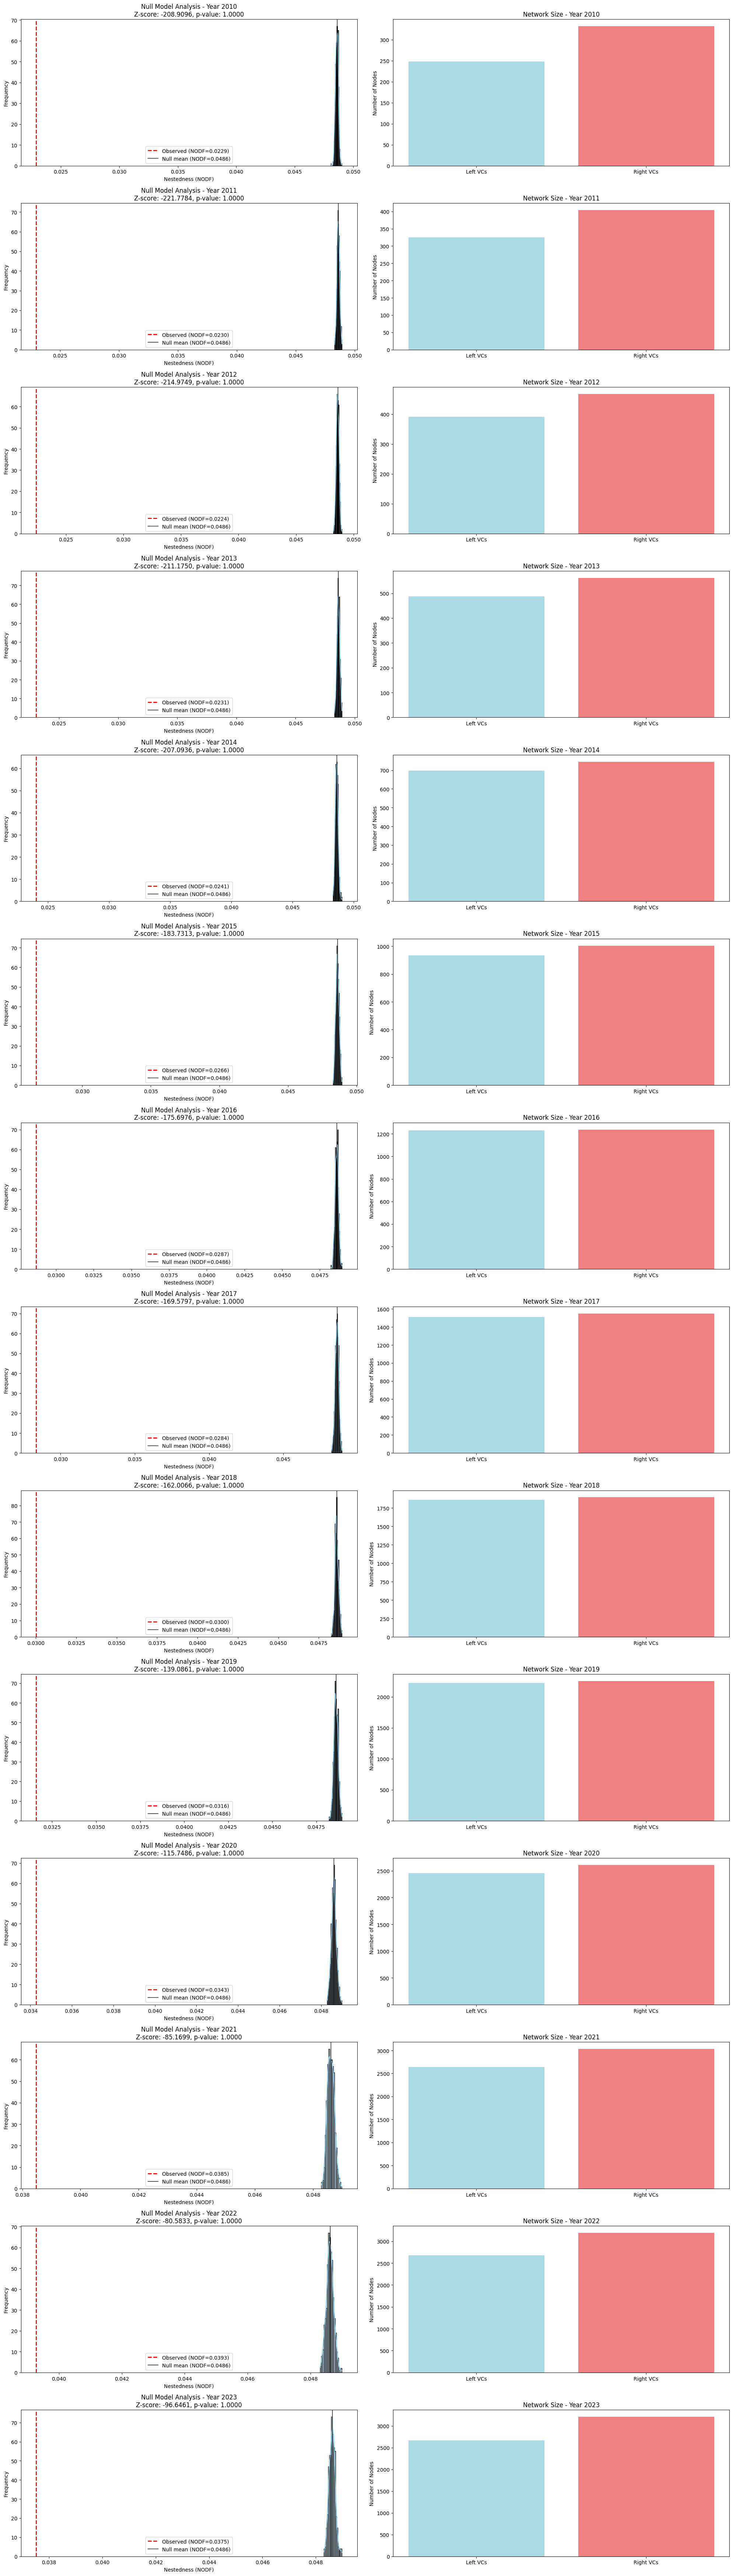

In [22]:
# Create visualizations for each year to show nestedness significance
fig, axes = plt.subplots(len(cumulative_nestedness_scores_df), 2, figsize=(20, 5*len(cumulative_nestedness_scores_df)))

for i, (idx, row) in enumerate(cumulative_nestedness_scores_df.iterrows()):
  year = row['year']
  nestedness_score = row['nestedness_score']
  null_nestedness_scores = row['null_nestedness_scores']
  mean_null = row['mean_null']
  std_null = row['std_null']
  z_score = row['z_score']
  p_value = row['p_value']
  
  # Print statistics for the year
  print(f"\nNestedness Significance Analysis for Year {year}:")
  print(f"Observed NODF: {nestedness_score:.4f}")
  print(f"Null model mean NODF: {mean_null:.4f}")
  print(f"Null model std dev: {std_null:.4f}")
  print(f"Z-score: {z_score:.4f}")
  print(f"Empirical p-value: {p_value:.4f}")
  print(f"Significance: {'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05")
  
  # Plot 1: Histogram of null model distribution
  sns.histplot(null_nestedness_scores, kde=True, color='skyblue', ax=axes[i, 0])
  axes[i, 0].axvline(nestedness_score, color='red', linestyle='--', linewidth=2, 
        label=f'Observed (NODF={nestedness_score:.4f})')
  axes[i, 0].axvline(mean_null, color='black', linestyle='-', linewidth=1, 
        label=f'Null mean (NODF={mean_null:.4f})')
  axes[i, 0].set_title(f'Null Model Analysis - Year {year}\nZ-score: {z_score:.4f}, p-value: {p_value:.4f}')
  axes[i, 0].set_xlabel('Nestedness (NODF)')
  axes[i, 0].set_ylabel('Frequency')
  axes[i, 0].legend()
  
  # Plot 2: Network properties
  ax2 = axes[i, 1]
  ax2.bar(['Left VCs', 'Right VCs'], [row['num_vcs_left'], row['num_vcs_right']], color=['lightblue', 'lightcoral'])
  ax2.set_title(f'Network Size - Year {year}')
  ax2.set_ylabel('Number of Nodes')
  
plt.tight_layout()
plt.show()